In [771]:
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import os
import pygwalker as pyg
from plotly.subplots import make_subplots
import nbformat
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from time import time
import pycountry
def convert_to_alpha3(code):
    try:
        return pycountry.countries.get(alpha_2=code).alpha_3
    except:
        return None

In [772]:
# Path to the folder with your JSON video files
folder_path = r"C:\Users\Ali\.cache\kagglehub\datasets\datasnaek\youtube-new\versions\115"  # <--- Change this to your folder path

# List to collect all video records
all_data = []

# Loop through all .json files in the folder
for file in os.listdir(folder_path):
    if file.endswith('.csv') and 'videos' in file.lower():
        file_path = os.path.join(folder_path, file)
        try:
            df = pd.read_csv(file_path, encoding='utf-8')
            print(f"✅ Loaded (UTF-8): {file} with {len(df)} rows")
        except UnicodeDecodeError:
            try:
                df = pd.read_csv(file_path, encoding='ISO-8859-1')
                print(f"✅ Loaded (ISO-8859-1): {file} with {len(df)} rows")
            except Exception as e:
                print(f"❌ Still failed: {file}: {e}")
                continue  # skip this file if both attempts fail
        df['source_file'] = file
        all_data.append(df)

df = pd.concat(all_data, ignore_index=True)
print("✅ Final combined shape:", df.shape)

# Optional: Save
df.to_csv("combined_youtube_data.csv", index=False)

✅ Loaded (UTF-8): CAvideos.csv with 40881 rows
✅ Loaded (UTF-8): DEvideos.csv with 40840 rows
✅ Loaded (UTF-8): FRvideos.csv with 40724 rows
✅ Loaded (UTF-8): GBvideos.csv with 38916 rows
✅ Loaded (UTF-8): INvideos.csv with 37352 rows
✅ Loaded (ISO-8859-1): JPvideos.csv with 20523 rows
✅ Loaded (ISO-8859-1): KRvideos.csv with 34567 rows
✅ Loaded (ISO-8859-1): MXvideos.csv with 40451 rows
✅ Loaded (ISO-8859-1): RUvideos.csv with 40739 rows
✅ Loaded (UTF-8): USvideos.csv with 40949 rows
✅ Final combined shape: (375942, 17)


In [773]:
print(df.head())

      video_id trending_date  \
0  n1WpP7iowLc      17.14.11   
1  0dBIkQ4Mz1M      17.14.11   
2  5qpjK5DgCt4      17.14.11   
3  d380meD0W0M      17.14.11   
4  2Vv-BfVoq4g      17.14.11   

                                               title channel_title  \
0         Eminem - Walk On Water (Audio) ft. Beyoncé    EminemVEVO   
1                      PLUSH - Bad Unboxing Fan Mail     iDubbbzTV   
2  Racist Superman | Rudy Mancuso, King Bach & Le...  Rudy Mancuso   
3                           I Dare You: GOING BALD!?      nigahiga   
4        Ed Sheeran - Perfect (Official Music Video)    Ed Sheeran   

   category_id              publish_time  \
0           10  2017-11-10T17:00:03.000Z   
1           23  2017-11-13T17:00:00.000Z   
2           23  2017-11-12T19:05:24.000Z   
3           24  2017-11-12T18:01:41.000Z   
4           10  2017-11-09T11:04:14.000Z   

                                                tags     views    likes  \
0  Eminem|"Walk"|"On"|"Water"|"Aftermath/Shady

In [774]:
df['trending_date'] = pd.to_datetime(df['trending_date'], format='%y.%d.%m')

In [775]:
df['publish_time'] = pd.to_datetime(df['publish_time'])

In [776]:
df['publish_date'] = df['publish_time'].dt.date
df['publish_hour'] = df['publish_time'].dt.hour

In [777]:
with open(r'C:\Users\Ali\.cache\kagglehub\datasets\datasnaek\youtube-new\versions\115\US_category_id.json') as f:
    category_data = json.load(f)

category_map = {int(item['id']): item['snippet']['title'] for item in category_data['items']}
df['category_name'] = df['category_id'].map(category_map)

In [778]:
print(df.head())

      video_id trending_date  \
0  n1WpP7iowLc    2017-11-14   
1  0dBIkQ4Mz1M    2017-11-14   
2  5qpjK5DgCt4    2017-11-14   
3  d380meD0W0M    2017-11-14   
4  2Vv-BfVoq4g    2017-11-14   

                                               title channel_title  \
0         Eminem - Walk On Water (Audio) ft. Beyoncé    EminemVEVO   
1                      PLUSH - Bad Unboxing Fan Mail     iDubbbzTV   
2  Racist Superman | Rudy Mancuso, King Bach & Le...  Rudy Mancuso   
3                           I Dare You: GOING BALD!?      nigahiga   
4        Ed Sheeran - Perfect (Official Music Video)    Ed Sheeran   

   category_id              publish_time  \
0           10 2017-11-10 17:00:03+00:00   
1           23 2017-11-13 17:00:00+00:00   
2           23 2017-11-12 19:05:24+00:00   
3           24 2017-11-12 18:01:41+00:00   
4           10 2017-11-09 11:04:14+00:00   

                                                tags     views    likes  \
0  Eminem|"Walk"|"On"|"Water"|"Aftermath/Shady

In [779]:
json_folder = r'C:\Users\Ali\.cache\kagglehub\datasets\datasnaek\youtube-new\versions\115'  # or wherever they are
category_map_by_country = {}
for file in os.listdir(json_folder):
    if file.endswith('_category_id.json'):
        country = file[:2]  # e.g., 'US'
        with open(os.path.join(json_folder, file), 'r', encoding='utf-8') as f:
            data = json.load(f)
            category_map = {int(item['id']): item['snippet']['title'] for item in data['items']}
            category_map_by_country[country] = category_map

In [780]:
print(df.head())
df=df.drop_duplicates()

      video_id trending_date  \
0  n1WpP7iowLc    2017-11-14   
1  0dBIkQ4Mz1M    2017-11-14   
2  5qpjK5DgCt4    2017-11-14   
3  d380meD0W0M    2017-11-14   
4  2Vv-BfVoq4g    2017-11-14   

                                               title channel_title  \
0         Eminem - Walk On Water (Audio) ft. Beyoncé    EminemVEVO   
1                      PLUSH - Bad Unboxing Fan Mail     iDubbbzTV   
2  Racist Superman | Rudy Mancuso, King Bach & Le...  Rudy Mancuso   
3                           I Dare You: GOING BALD!?      nigahiga   
4        Ed Sheeran - Perfect (Official Music Video)    Ed Sheeran   

   category_id              publish_time  \
0           10 2017-11-10 17:00:03+00:00   
1           23 2017-11-13 17:00:00+00:00   
2           23 2017-11-12 19:05:24+00:00   
3           24 2017-11-12 18:01:41+00:00   
4           10 2017-11-09 11:04:14+00:00   

                                                tags     views    likes  \
0  Eminem|"Walk"|"On"|"Water"|"Aftermath/Shady

In [781]:
def get_category_name(row):
    country = row['source_file'][:2]  # e.g., 'US' from 'USvideos.csv'
    category_id = row['category_id']
    return category_map_by_country.get(country, {}).get(category_id, 'Unknown')

df['category_name'] = df.apply(get_category_name, axis=1)

In [782]:
df_sorted=df.sort_values(by='views',ascending=False)
df_sorted.tail()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,source_file,publish_date,publish_hour,category_name
314018,p3YzdrKZzAw,2018-02-22,ÐÐ½Ð¸ÑÐ¸Ð¼Ð¾Ð² Ð·Ð°Ð±Ð¸Ð» Ñ Ð¿Ð°ÑÐ° ÐÐµÐ¹...,NHL.COM/RU,17,2018-02-22 05:23:46+00:00,"ÐÑÑÐµÐ¼ ÐÐ½Ð¸ÑÐ¸Ð¼Ð¾Ð²|""ÐÐ¥Ð""|""Ð¥Ð¾ÐºÐº...",164,15,0,1,https://i.ytimg.com/vi/p3YzdrKZzAw/default.jpg,False,False,False,ÐÑÑÐµÐ¼ ÐÐ½Ð¸ÑÐ¸Ð¼Ð¾Ð² Ñ Ð±Ð»Ð¸Ð·ÐºÐ¾Ð³Ð...,RUvideos.csv,2018-02-22,5,Sports
314599,8_xuskv0SVw,2018-02-25,Ð ÐÐ¡Ð¡ÐÐ¯ - ÐÐÐ ÐÐÐÐÐ¯ ÐÐÐÐ« Ð Ð...,Sport Life,22,2018-02-25 06:58:40+00:00,"ÐÐ»Ð¸Ð¼Ð¿Ð¸Ð°Ð´Ð°|""2018""|""Ð¥Ð¾ÐºÐºÐµÐ¹""|""Ð Ð¾...",163,15,3,5,https://i.ytimg.com/vi/8_xuskv0SVw/default.jpg,False,False,False,ÐÐÐÐÐÐÐÐÐ 2018 Ð ÐÐ¡Ð¡ÐÐ¯ ÐÐÐ ÐÐ...,RUvideos.csv,2018-02-25,6,People & Blogs
256364,AH9CPLoIWu4,2017-11-26,RESUMEN CELAYA VS ALEBRIJES ASCENSO MX 2017,Ascenso MX,17,2017-11-26 06:05:11+00:00,"RESUMEN CELAYA VS ALEBRIJES ASCENSO MX 2017|""R...",157,16,3,7,https://i.ytimg.com/vi/AH9CPLoIWu4/default.jpg,False,False,False,RESUMEN CELAYA VS ALEBRIJES SEMIFINAL VUELTA A...,MXvideos.csv,2017-11-26,6,Sports
314568,kz9Q2oALmWE,2018-02-25,Ð Ð¾ÑÑÐ¸Ñ - ÐÐµÑÐ¼Ð°Ð½Ð¸Ñ. Ð¡ÑÐµÑ 4:3....,Alexander Redking,17,2018-02-25 06:57:15+00:00,"Ð½Ð¾Ð²Ð¾ÑÑÐ¸|""ÑÐ¾Ð±ÑÑÐ¸Ñ""|""ÑÐ¿Ð¾ÑÑ""|""...",153,12,2,1,https://i.ytimg.com/vi/kz9Q2oALmWE/default.jpg,False,False,False,ÐÑÑÐ¾ÑÐ½Ð¸Ðº: https://twitter.com/sport_fm...,RUvideos.csv,2018-02-25,6,Sports
309199,PcIF_Z-IQgk,2018-01-29,ÐÐ°Ð²Ð°Ð»ÑÐ½ÑÐ¹ ÑÐ´ÑÐ»ÑÑ. ÐÐ½Ð°Ð»Ð¸ Ð»...,ÐÐ²Ð»Ð½Ð¹ Ð¥Ð»Ð¾ 2.0,22,2018-01-29 05:32:10+00:00,#ÐÐ°Ð²Ð°Ð»ÑÐ½ÑÐ¹ #ÐÐµÑÐ°ÐÐ°Ð²Ð°Ð»ÑÐ½ÑÐ...,117,4,2,13,https://i.ytimg.com/vi/PcIF_Z-IQgk/default.jpg,False,False,False,28.01.18 ÐÐ¾ Ð²ÑÐµÐ¼Ñ Ð¿Ð¾ÑÐ»ÐµÐ´Ð½ÐµÐ¹ Ñ...,RUvideos.csv,2018-01-29,5,People & Blogs


## <div style=" background-color:black; padding: 10px; border-radius: 5px;color:#d4edda"> This Means that the most watched videos on youtube are categorized as 'Music' ones, The Least Watched Videos are categorized as 'Shows'

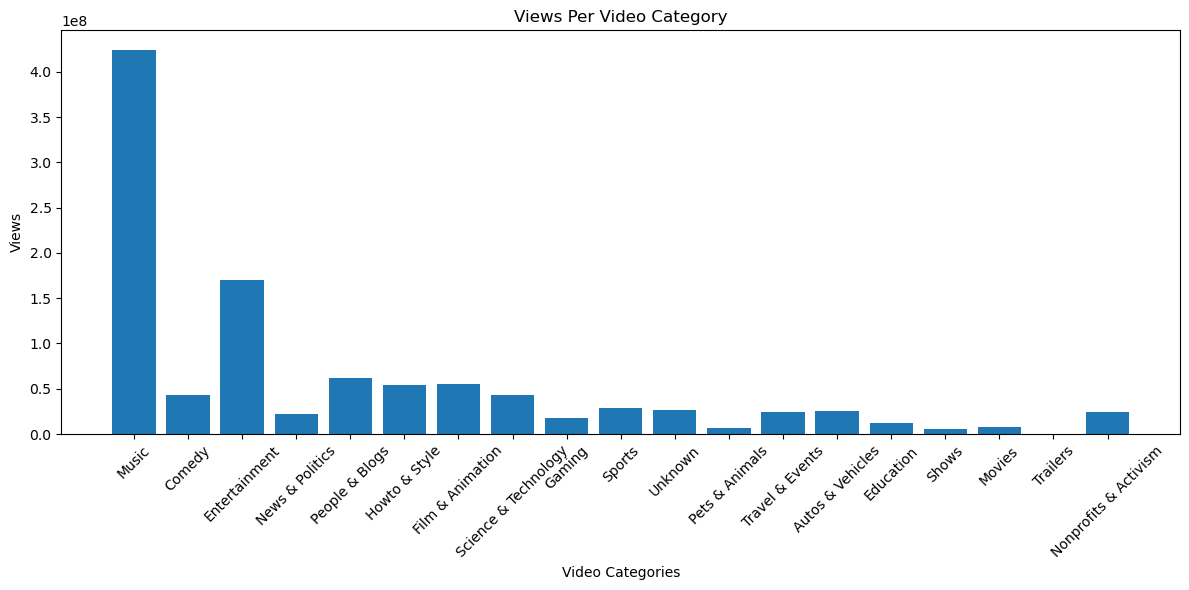

In [784]:
plt.figure(figsize=(12,6))
plt.bar(df['category_name'],df['views'])
plt.xlabel('Video Categories')
plt.ylabel('Views')
plt.title('Views Per Video Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## <div style=" background-color:black; padding: 10px; border-radius: 5px;color:#d4edda"> This is a Bar Chart that shows this info 

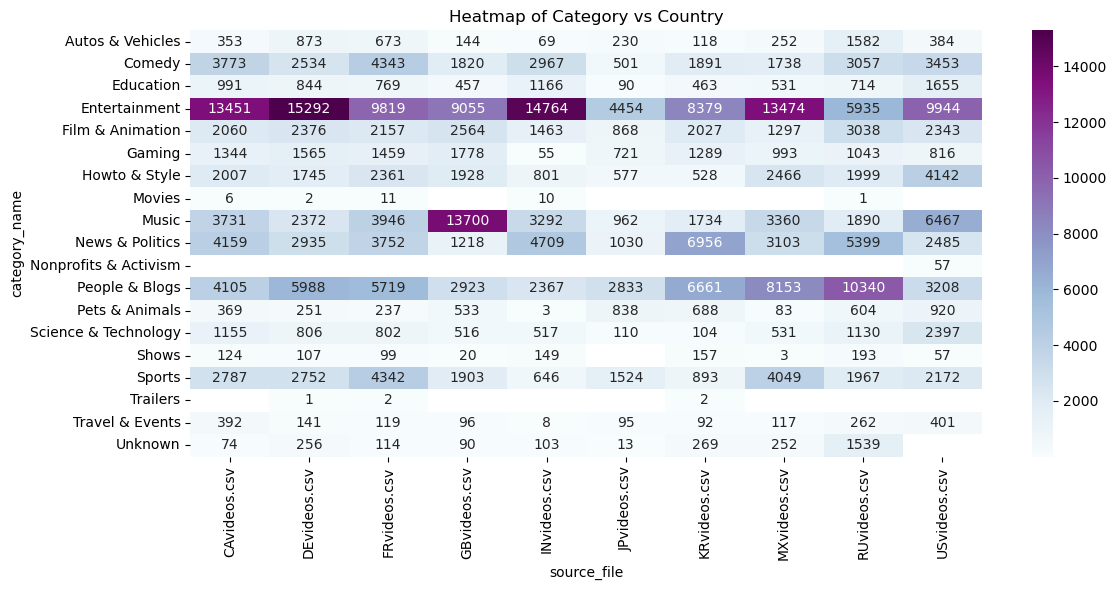

In [786]:
heatmap_data = df.groupby(['category_name', 'source_file']).size().unstack()
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, fmt='g', cmap='BuPu')
plt.title('Heatmap of Category vs Country')
plt.tight_layout()
plt.show()

## <div style=" background-color:black; padding: 10px; border-radius: 5px;color:#d4edda"> This is a heatmap showing the Category vs Country. Here we can see that the most watched videos in Canada, Germany, France, India, Japan, South Korea, Mexico and United States are categorized as 'Entertainment' Videos, otherwise Music videos are the most watched in United Kingdom and in Russia 'People & Blogs' videos are the most watched.



In [788]:
us_likes=df.query("source_file=='USvideos.csv'")['likes'].sum()
print(f"Total US likes :{us_likes}")
us_views=df.query("source_file=='USvideos.csv'")['views'].sum()
print(f"Total US Views :{us_views}")
US_likes_per_views=us_likes/us_views
print(f"US Likes/Views = {US_likes_per_views}")

Total US likes :3037788204
Total US Views :96554092462
US Likes/Views = 0.03146203466409834


In [789]:
df['country'] = df['source_file'] # Add country column if not done
likes_by_country = df.groupby('country')['likes'].sum().sort_values(ascending=False)
print(likes_by_country)
views_by_country=df.groupby('country')['views'].sum().sort_values(ascending=False)
print(views_by_country)
print(likes_by_country/views_by_country)
(likes_by_country/views_by_country).sort_values(ascending=False)

country
GBvideos.csv    5209935076
USvideos.csv    3037788204
CAvideos.csv    1618179878
DEvideos.csv     893395538
INvideos.csv     846668793
FRvideos.csv     708144090
MXvideos.csv     635397043
RUvideos.csv     500643513
KRvideos.csv     388916711
JPvideos.csv     119264413
Name: likes, dtype: int64
country
GBvideos.csv    229033033628
USvideos.csv     96554092462
CAvideos.csv     46891975069
INvideos.csv     32967977200
DEvideos.csv     24645115205
FRvideos.csv     17100897444
MXvideos.csv     13743748500
KRvideos.csv     13654532085
RUvideos.csv      9718024889
JPvideos.csv      3766449325
Name: views, dtype: int64
country
CAvideos.csv    0.034509
DEvideos.csv    0.036250
FRvideos.csv    0.041410
GBvideos.csv    0.022748
INvideos.csv    0.025682
JPvideos.csv    0.031665
KRvideos.csv    0.028483
MXvideos.csv    0.046232
RUvideos.csv    0.051517
USvideos.csv    0.031462
dtype: float64


country
RUvideos.csv    0.051517
MXvideos.csv    0.046232
FRvideos.csv    0.041410
DEvideos.csv    0.036250
CAvideos.csv    0.034509
JPvideos.csv    0.031665
USvideos.csv    0.031462
KRvideos.csv    0.028483
INvideos.csv    0.025682
GBvideos.csv    0.022748
dtype: float64

C:\Users\Ali\AppData\Local\Temp\ipykernel_27976\3229693842.py:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




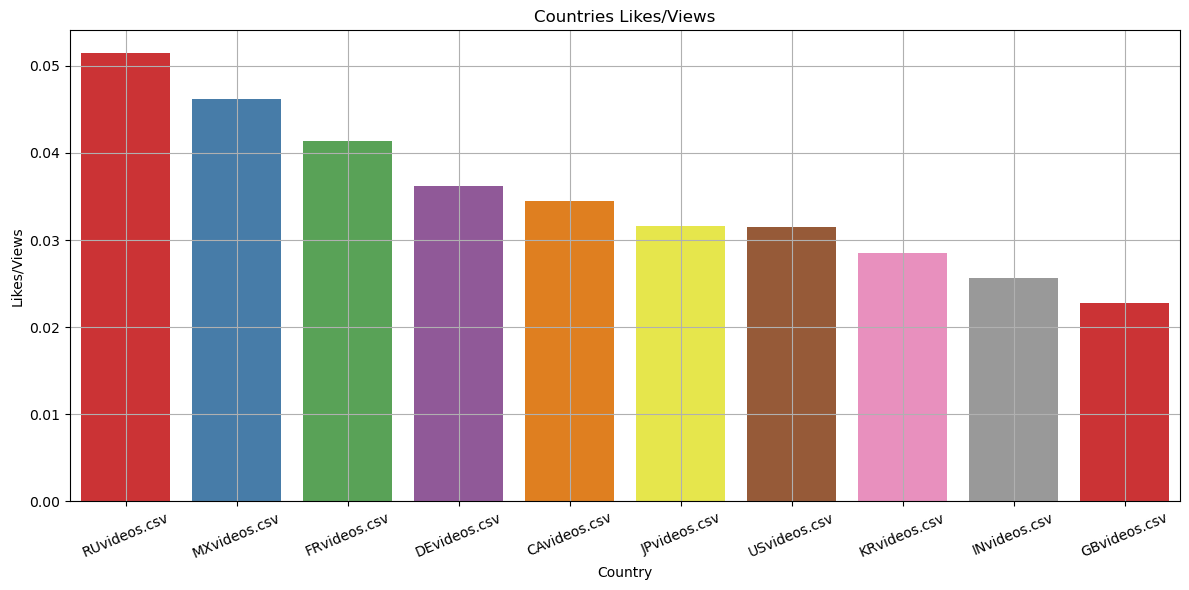

In [790]:
ratio_by_country = (likes_by_country / views_by_country).sort_values(ascending=False)
ratio_df = ratio_by_country.reset_index()
ratio_df.columns = ['country', 'like_view_ratio']  # rename columns

plt.figure(figsize=(12,6))
sns.barplot(x='country',y='like_view_ratio',data=ratio_df,palette='Set1')
plt.title('Countries Likes/Views')
plt.xlabel('Country')
plt.ylabel('Likes/Views')
plt.xticks(rotation=23)
plt.grid(True)
plt.tight_layout()
plt.show()

## <div style=" background-color:black; padding: 10px; border-radius: 5px;color:#d4edda"> As Shown Here the country with the Most Likes-to-views ratio is Russia (RU is the country code for Russia) followed by Mexico, United-Kingdom has the Lowest Likes-to-Views Ratio.

In [792]:
df.columns

Index(['video_id', 'trending_date', 'title', 'channel_title', 'category_id',
       'publish_time', 'tags', 'views', 'likes', 'dislikes', 'comment_count',
       'thumbnail_link', 'comments_disabled', 'ratings_disabled',
       'video_error_or_removed', 'description', 'source_file', 'publish_date',
       'publish_hour', 'category_name', 'country'],
      dtype='object')

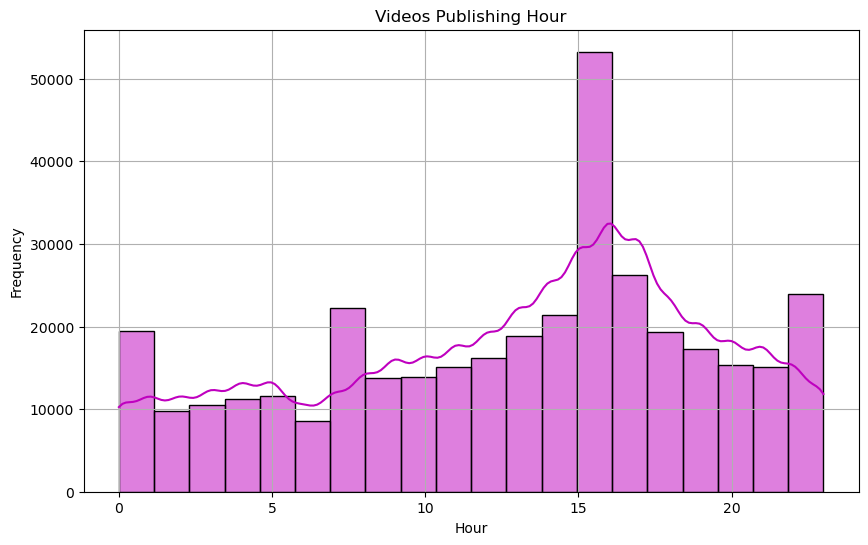

In [793]:
plt.figure(figsize=(10,6))
sns.histplot(df['publish_hour'],kde=True,color='m',bins=20)
plt.title('Videos Publishing Hour')
plt.xlabel('Hour')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [794]:
df['publish_hour'].value_counts().idxmax()

16

## <div style=" background-color:black; padding: 10px; border-radius: 5px;color:#d4edda"> Most of the Videos were published at 16:00

In [796]:
views_per_hour=df.groupby('publish_hour')['views'].mean()
views_per_hour

publish_hour
0     1.618990e+06
1     1.297662e+06
2     1.041660e+06
3     1.188027e+06
4     3.903610e+06
5     3.780757e+06
6     8.554480e+05
7     1.058623e+06
8     1.248433e+06
9     1.343854e+06
10    9.075630e+05
11    8.676811e+05
12    1.269307e+06
13    1.397169e+06
14    1.434975e+06
15    1.215580e+06
16    1.135140e+06
17    1.167164e+06
18    9.634530e+05
19    7.661908e+05
20    1.111193e+06
21    1.287821e+06
22    1.516454e+06
23    1.172944e+06
Name: views, dtype: float64

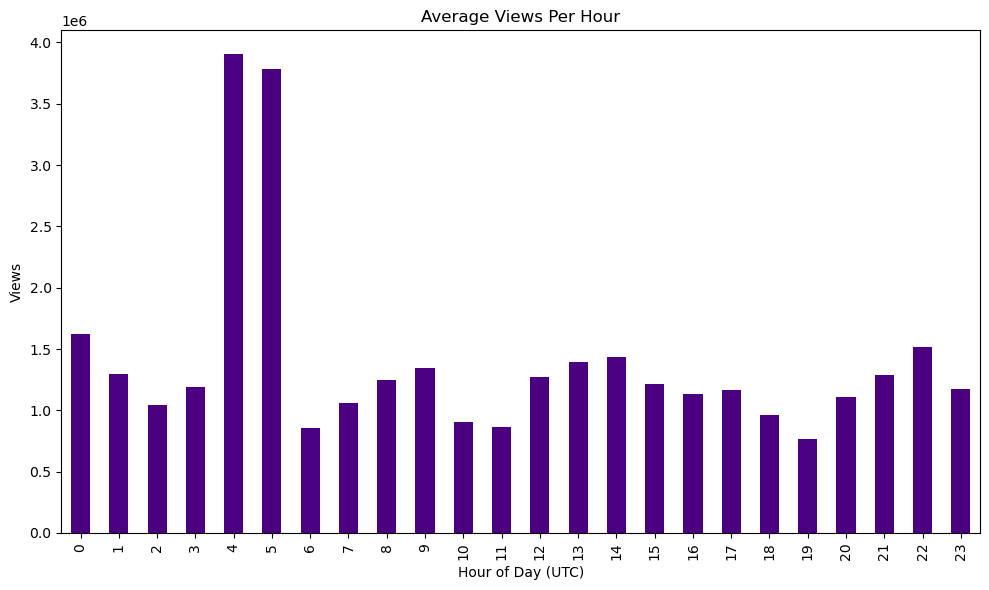

In [797]:
plt.figure(figsize=(10,6))
views_per_hour.plot(kind='bar',color='indigo')
plt.title('Average Views Per Hour')
plt.xlabel('Hour of Day (UTC)')
plt.ylabel('Views')
plt.tight_layout()
plt.grid(False)
plt.show()

## <div style=" background-color:black; padding: 10px; border-radius: 5px;color:#d4edda"> The Most Average Views Per Hour are at 4 PM (UTC Time), So The best time in the day to publish a video should be around 3-4 PM 

In [799]:
df['channel_title'].value_counts().mean()

9.52357489188835

In [800]:
channels=df.groupby('country')['channel_title'].sum()
channels

country
CAvideos.csv    EminemVEVOiDubbbzTVRudy MancusonigahigaEd Shee...
DEvideos.csv    inscope21LUKE! Die Woche und ichLastWeekTonigh...
FRvideos.csv    Le Raptor DissidentLe LaboDaniil le RusseJoueu...
GBvideos.csv    John LewisSaturday Night LiveEminemVEVOSalford...
INvideos.csv    Lokdhun PunjabiHJ NEWSTFPCEruma SaaniFilmylook...
JPvideos.csv    æäºéä¿¡æ åã»ã³ã¿ã¼ç¥è°·ãããª ...
KRvideos.csv    ë¼í¸ë§ì½ë¦¬ìEdwardëëª°ë¼í¨ë°ë¦¬ í«...
MXvideos.csv    MasterChef 2017Micky Contreras MartinezEl Puls...
RUvideos.csv    Ð¢âÐ ÐÐÐÐÐ§Druzhko ShowÐ®Ð»Ð¸ÐºHochland...
USvideos.csv    CaseyNeistatLastWeekTonightRudy MancusoGood My...
Name: channel_title, dtype: object

In [801]:
df.columns

Index(['video_id', 'trending_date', 'title', 'channel_title', 'category_id',
       'publish_time', 'tags', 'views', 'likes', 'dislikes', 'comment_count',
       'thumbnail_link', 'comments_disabled', 'ratings_disabled',
       'video_error_or_removed', 'description', 'source_file', 'publish_date',
       'publish_hour', 'category_name', 'country'],
      dtype='object')

In [802]:
channels_by_country=(
    df.groupby(['country','channel_title']).size().reset_index(name='video_count')
)
top_channels_per_country=(
    channels_by_country.sort_values(['country','video_count'],ascending=False).
    groupby('country').
    head(5)
)

C:\Users\Ali\AppData\Local\Temp\ipykernel_27976\156369597.py:11: UserWarning:

Glyph 144 (\x90) missing from current font.

C:\Users\Ali\AppData\Local\Temp\ipykernel_27976\156369597.py:11: UserWarning:

Glyph 130 (\x82) missing from current font.

C:\Users\Ali\AppData\Local\Temp\ipykernel_27976\156369597.py:11: UserWarning:

Glyph 128 (\x80) missing from current font.

C:\Users\Ali\AppData\Local\Temp\ipykernel_27976\156369597.py:11: UserWarning:

Glyph 133 (\x85) missing from current font.

C:\Users\Ali\AppData\Local\Temp\ipykernel_27976\156369597.py:11: UserWarning:

Glyph 156 (\x9c) missing from current font.

C:\Users\Ali\AppData\Local\Temp\ipykernel_27976\156369597.py:11: UserWarning:

Glyph 129 (\x81) missing from current font.

C:\Users\Ali\AppData\Local\Temp\ipykernel_27976\156369597.py:11: UserWarning:

Glyph 139 (\x8b) missing from current font.

C:\Users\Ali\AppData\Local\Temp\ipykernel_27976\156369597.py:11: UserWarning:

Glyph 159 (\x9f) missing from current font.

C:\Users

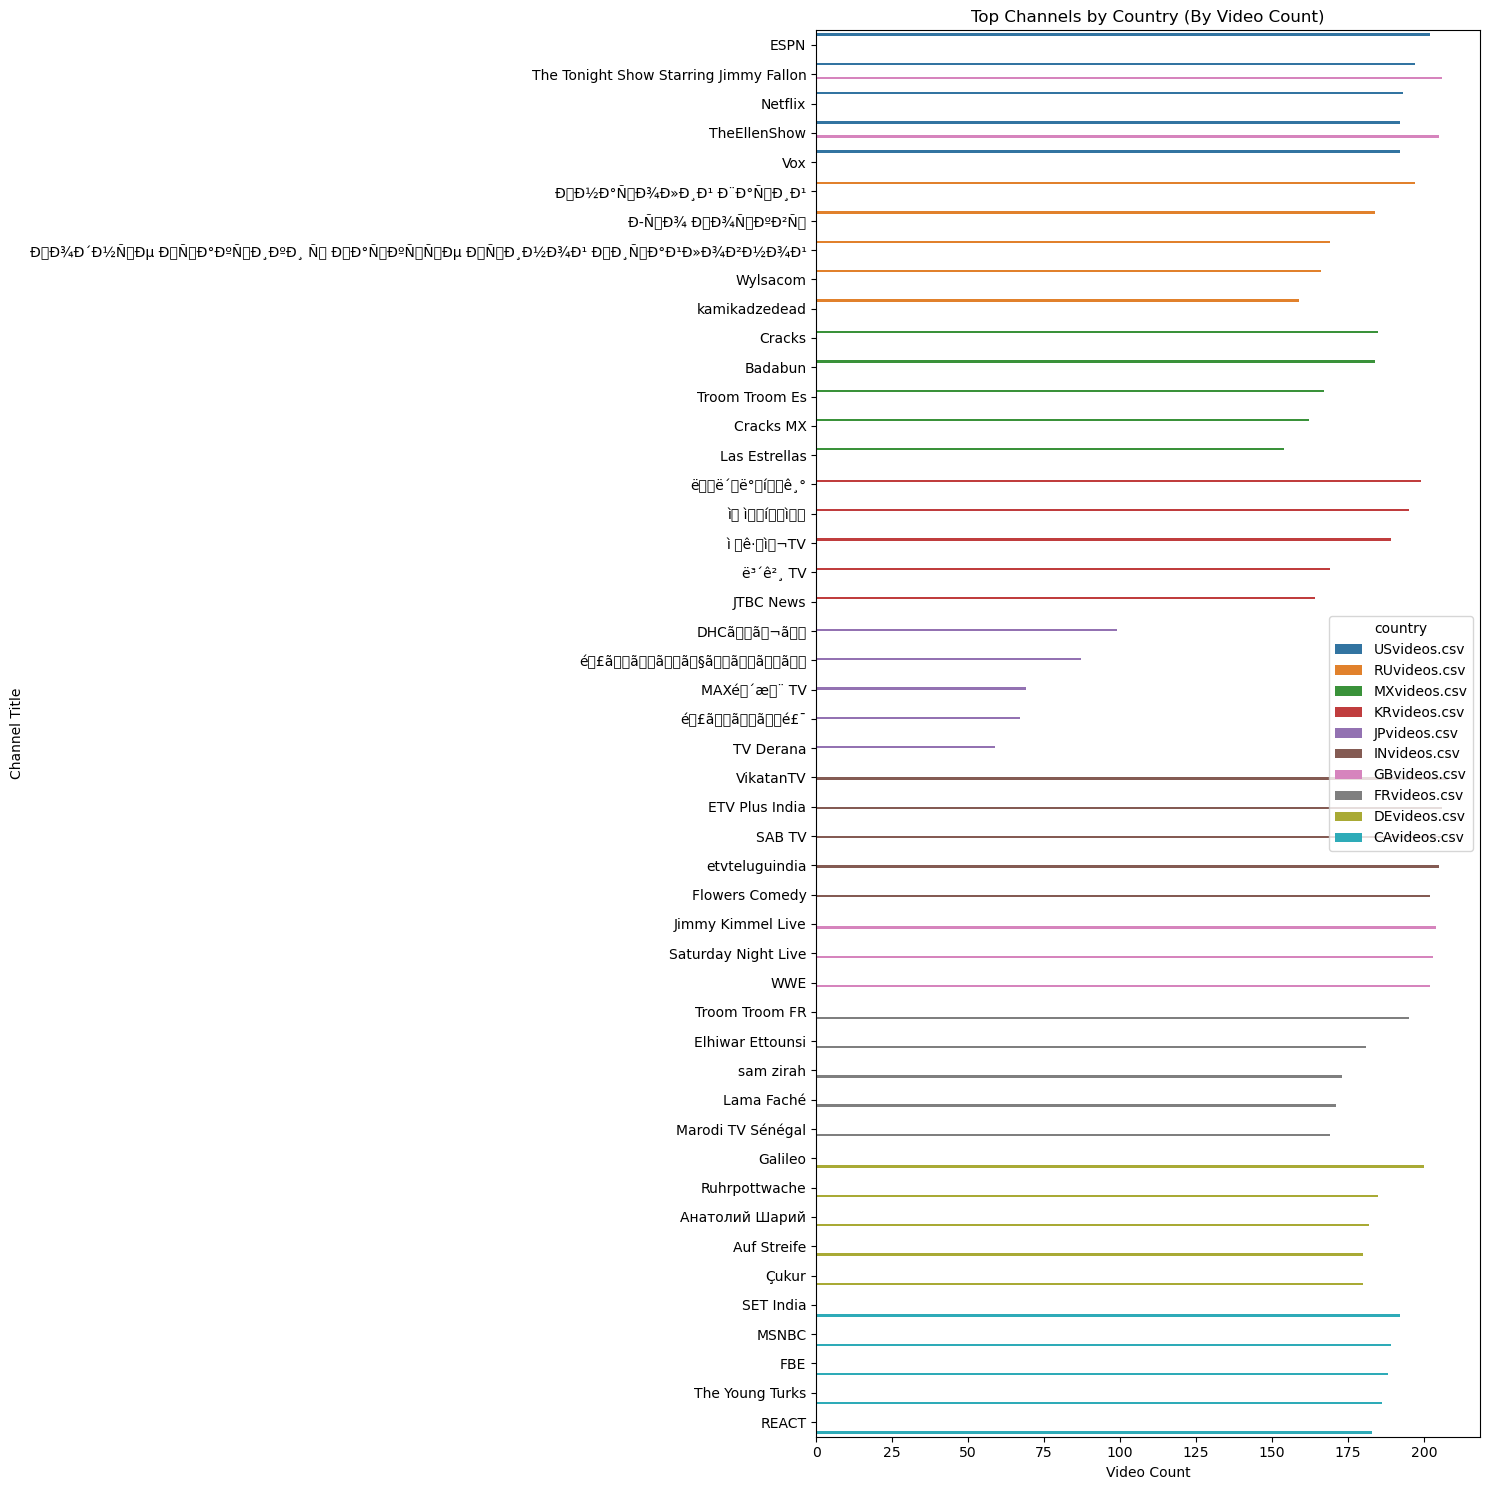

In [803]:
plt.figure(figsize=(15,15))
sns.barplot(
    data=top_channels_per_country,
    x='video_count',
    y='channel_title',
    hue='country'
)
plt.title('Top Channels by Country (By Video Count)')
plt.xlabel('Video Count')
plt.ylabel('Channel Title')
plt.tight_layout()
plt.show()

## <div style=" background-color:black; padding: 10px; border-radius: 5px;color:#d4edda"> As shown here, the more videos a channel has, the more views and engagement it receives

In [805]:
df_engagements_vs_views=df[['views','likes','comment_count']]

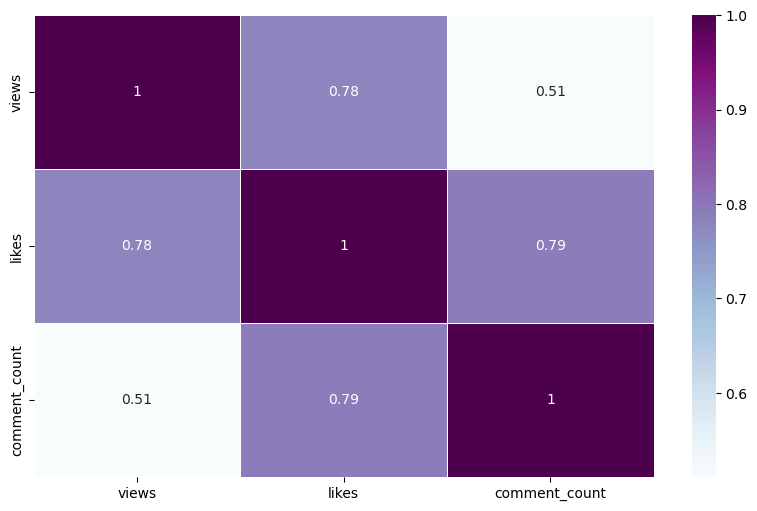

In [806]:
plt.figure(figsize=(10,6))
sns.heatmap(df_engagements_vs_views.corr(),annot=True,cmap='BuPu',linewidths=0.5)
plt.show()

## <div style=" background-color:black; padding: 10px; border-radius: 5px;color:#d4edda"> There is a strong Correlation between likes and views, this means that the more views the video gets the more likes it will get too, on the other hand comments has weak correlation with views, so even if the video gets a lot of views that doesn't mean that the video will get more comments

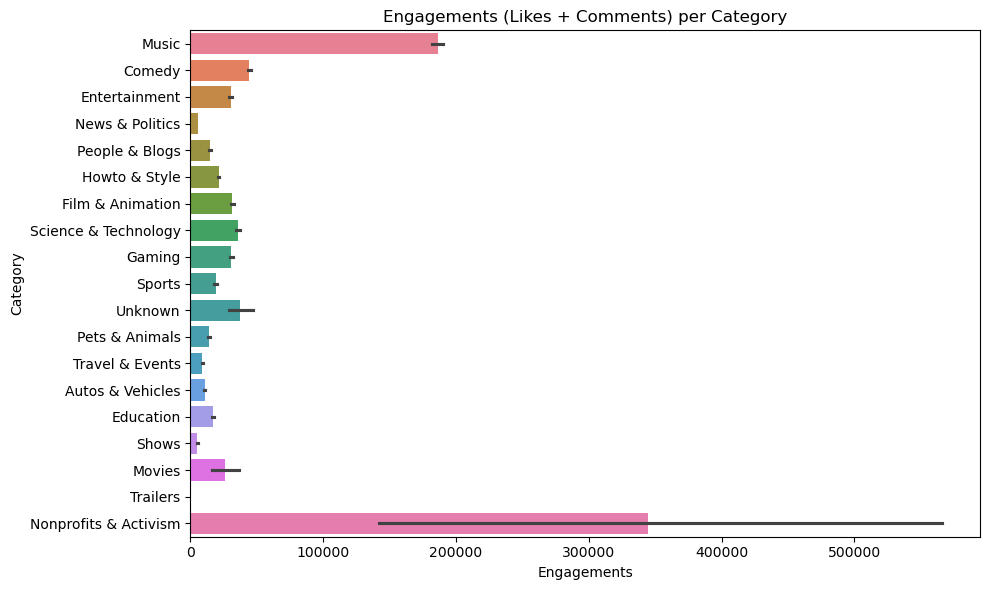

In [808]:
df['engagements']=df['comment_count']+df['likes']
plt.figure(figsize=(10,6))
sns.barplot(
    data=df,
    x='engagements',
    y='category_name',
    hue='category_name'
)
plt.title('Engagements (Likes + Comments) per Category')
plt.xlabel('Engagements')
plt.ylabel('Category')
plt.tight_layout()
plt.show()

## <div style=" background-color:black; padding: 10px; border-radius: 5px;color:#d4edda"> Here is a Bar Plot including the engagements (Likes + Comments) of people in each category, We see that the 'Nonprofits & Activism' got a huge number of engagements (There are outliers here but this is possible depending on the virality of the video, so there is no need to remove them).

In [810]:
Q1=df['engagements'].quantile(0.25)
Q3=df['likes'].quantile(0.75)
IQR=Q3-Q1
outliers=df[(df['engagements']<Q1-1.5*IQR) | (df['engagements']>Q3+1.5*IQR)]
outliers

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,...,comments_disabled,ratings_disabled,video_error_or_removed,description,source_file,publish_date,publish_hour,category_name,country,engagements
0,n1WpP7iowLc,2017-11-14,Eminem - Walk On Water (Audio) ft. Beyoncé,EminemVEVO,10,2017-11-10 17:00:03+00:00,"Eminem|""Walk""|""On""|""Water""|""Aftermath/Shady/In...",17158579,787425,43420,...,False,False,False,Eminem's new track Walk on Water ft. Beyoncé i...,CAvideos.csv,2017-11-10,17,Music,CAvideos.csv,913307
1,0dBIkQ4Mz1M,2017-11-14,PLUSH - Bad Unboxing Fan Mail,iDubbbzTV,23,2017-11-13 17:00:00+00:00,"plush|""bad unboxing""|""unboxing""|""fan mail""|""id...",1014651,127794,1688,...,False,False,False,STill got a lot of packages. Probably will las...,CAvideos.csv,2017-11-13,17,Comedy,CAvideos.csv,140824
2,5qpjK5DgCt4,2017-11-14,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12 19:05:24+00:00,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146035,5339,...,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...,CAvideos.csv,2017-11-12,19,Comedy,CAvideos.csv,154216
3,d380meD0W0M,2017-11-14,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12 18:01:41+00:00,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095828,132239,1989,...,False,False,False,I know it's been a while since we did this sho...,CAvideos.csv,2017-11-12,18,Entertainment,CAvideos.csv,149757
4,2Vv-BfVoq4g,2017-11-14,Ed Sheeran - Perfect (Official Music Video),Ed Sheeran,10,2017-11-09 11:04:14+00:00,"edsheeran|""ed sheeran""|""acoustic""|""live""|""cove...",33523622,1634130,21082,...,False,False,False,🎧: https://ad.gt/yt-perfect\n💰: https://atlant...,CAvideos.csv,2017-11-09,11,Music,CAvideos.csv,1719197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375936,1PhPYr_9zRY,2018-06-14,BTS Plays With Puppies While Answering Fan Que...,BuzzFeed Celeb,22,2018-05-18 16:39:29+00:00,"BuzzFeed|""BuzzFeedVideo""|""Puppy Interview""|""pu...",8259128,645888,4052,...,False,False,False,"BTS with the PPS, the puppies. These adorable ...",USvideos.csv,2018-05-18,16,People & Blogs,USvideos.csv,708498
375938,1h7KV2sjUWY,2018-06-14,True Facts : Ant Mutualism,zefrank1,22,2018-05-18 01:00:06+00:00,[none],1064798,60008,382,...,False,False,False,NaN,USvideos.csv,2018-05-18,1,People & Blogs,USvideos.csv,63944
375939,D6Oy4LfoqsU,2018-06-14,I GAVE SAFIYA NYGAARD A PERFECT HAIR MAKEOVER ...,Brad Mondo,24,2018-05-18 17:34:22+00:00,I gave safiya nygaard a perfect hair makeover ...,1066451,48068,1032,...,False,False,False,I had so much fun transforming Safiyas hair in...,USvideos.csv,2018-05-18,17,Entertainment,USvideos.csv,52060
375940,oV0zkMe1K8s,2018-06-14,How Black Panther Should Have Ended,How It Should Have Ended,1,2018-05-17 17:00:04+00:00,"Black Panther|""HISHE""|""Marvel""|""Infinity War""|...",5660813,192957,2846,...,False,False,False,How Black Panther Should Have EndedWatch More ...,USvideos.csv,2018-05-17,17,Film & Animation,USvideos.csv,206045


In [811]:
df['country_codes']=df['country'].str[0:2]
df['country_codes']=df['country_codes'].apply(convert_to_alpha3)

In [812]:
df['country_codes']

0         CAN
1         CAN
2         CAN
3         CAN
4         CAN
         ... 
375937    USA
375938    USA
375939    USA
375940    USA
375941    USA
Name: country_codes, Length: 363372, dtype: object

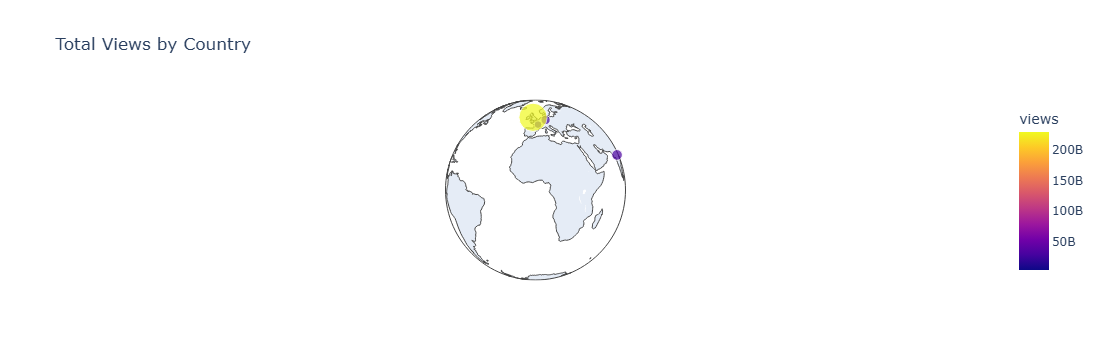

In [813]:
country_views=df.groupby('country_codes')['views'].sum().reset_index()
fig=px.scatter_geo(
    country_views,
    locations='country_codes',
    color='views',
    size='views',
    hover_name='country_codes',
    projection='orthographic',
    title='Total Views by Country'
)
fig.show()

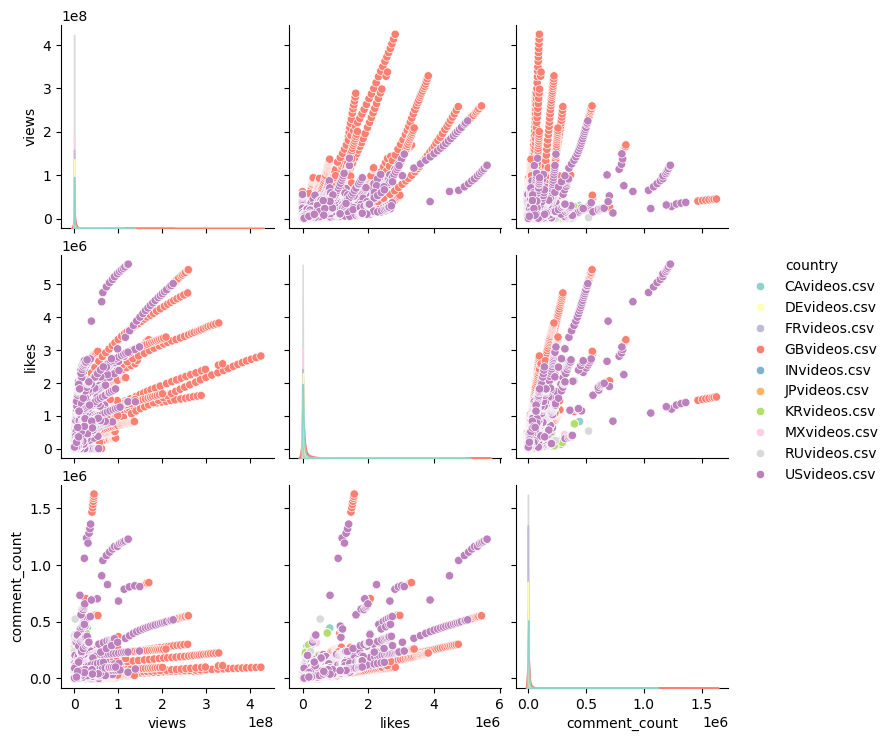

In [814]:
df_engagements_vs_views=df_engagements_vs_views.copy()
df_engagements_vs_views['country']=df['country']
sns.pairplot(df_engagements_vs_views,hue='country',palette='Set3')
plt.show()

In [815]:
df

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,...,ratings_disabled,video_error_or_removed,description,source_file,publish_date,publish_hour,category_name,country,engagements,country_codes
0,n1WpP7iowLc,2017-11-14,Eminem - Walk On Water (Audio) ft. Beyoncé,EminemVEVO,10,2017-11-10 17:00:03+00:00,"Eminem|""Walk""|""On""|""Water""|""Aftermath/Shady/In...",17158579,787425,43420,...,False,False,Eminem's new track Walk on Water ft. Beyoncé i...,CAvideos.csv,2017-11-10,17,Music,CAvideos.csv,913307,CAN
1,0dBIkQ4Mz1M,2017-11-14,PLUSH - Bad Unboxing Fan Mail,iDubbbzTV,23,2017-11-13 17:00:00+00:00,"plush|""bad unboxing""|""unboxing""|""fan mail""|""id...",1014651,127794,1688,...,False,False,STill got a lot of packages. Probably will las...,CAvideos.csv,2017-11-13,17,Comedy,CAvideos.csv,140824,CAN
2,5qpjK5DgCt4,2017-11-14,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12 19:05:24+00:00,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146035,5339,...,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...,CAvideos.csv,2017-11-12,19,Comedy,CAvideos.csv,154216,CAN
3,d380meD0W0M,2017-11-14,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12 18:01:41+00:00,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095828,132239,1989,...,False,False,I know it's been a while since we did this sho...,CAvideos.csv,2017-11-12,18,Entertainment,CAvideos.csv,149757,CAN
4,2Vv-BfVoq4g,2017-11-14,Ed Sheeran - Perfect (Official Music Video),Ed Sheeran,10,2017-11-09 11:04:14+00:00,"edsheeran|""ed sheeran""|""acoustic""|""live""|""cove...",33523622,1634130,21082,...,False,False,🎧: https://ad.gt/yt-perfect\n💰: https://atlant...,CAvideos.csv,2017-11-09,11,Music,CAvideos.csv,1719197,CAN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375937,BZt0qjTWNhw,2018-06-14,The Cat Who Caught the Laser,AaronsAnimals,15,2018-05-18 13:00:04+00:00,"aarons animals|""aarons""|""animals""|""cat""|""cats""...",1685609,38160,1385,...,False,False,The Cat Who Caught the Laser - Aaron's Animals,USvideos.csv,2018-05-18,13,Pets & Animals,USvideos.csv,40817,USA
375938,1h7KV2sjUWY,2018-06-14,True Facts : Ant Mutualism,zefrank1,22,2018-05-18 01:00:06+00:00,[none],1064798,60008,382,...,False,False,NaN,USvideos.csv,2018-05-18,1,People & Blogs,USvideos.csv,63944,USA
375939,D6Oy4LfoqsU,2018-06-14,I GAVE SAFIYA NYGAARD A PERFECT HAIR MAKEOVER ...,Brad Mondo,24,2018-05-18 17:34:22+00:00,I gave safiya nygaard a perfect hair makeover ...,1066451,48068,1032,...,False,False,I had so much fun transforming Safiyas hair in...,USvideos.csv,2018-05-18,17,Entertainment,USvideos.csv,52060,USA
375940,oV0zkMe1K8s,2018-06-14,How Black Panther Should Have Ended,How It Should Have Ended,1,2018-05-17 17:00:04+00:00,"Black Panther|""HISHE""|""Marvel""|""Infinity War""|...",5660813,192957,2846,...,False,False,How Black Panther Should Have EndedWatch More ...,USvideos.csv,2018-05-17,17,Film & Animation,USvideos.csv,206045,USA


In [816]:
df.columns

Index(['video_id', 'trending_date', 'title', 'channel_title', 'category_id',
       'publish_time', 'tags', 'views', 'likes', 'dislikes', 'comment_count',
       'thumbnail_link', 'comments_disabled', 'ratings_disabled',
       'video_error_or_removed', 'description', 'source_file', 'publish_date',
       'publish_hour', 'category_name', 'country', 'engagements',
       'country_codes'],
      dtype='object')

In [817]:
df['tags']

0         Eminem|"Walk"|"On"|"Water"|"Aftermath/Shady/In...
1         plush|"bad unboxing"|"unboxing"|"fan mail"|"id...
2         racist superman|"rudy"|"mancuso"|"king"|"bach"...
3         ryan|"higa"|"higatv"|"nigahiga"|"i dare you"|"...
4         edsheeran|"ed sheeran"|"acoustic"|"live"|"cove...
                                ...                        
375937    aarons animals|"aarons"|"animals"|"cat"|"cats"...
375938                                               [none]
375939    I gave safiya nygaard a perfect hair makeover ...
375940    Black Panther|"HISHE"|"Marvel"|"Infinity War"|...
375941        call of duty|"cod"|"activision"|"Black Ops 4"
Name: tags, Length: 363372, dtype: object

In [818]:
df['tag_count'] = df['tags'].apply(lambda x: 0 if x == '[none]' else len(x.split('|')))

In [819]:
df['tag_count']

0          6
1         11
2         23
3         14
4         10
          ..
375937    14
375938     0
375939    24
375940    22
375941     4
Name: tag_count, Length: 363372, dtype: int64

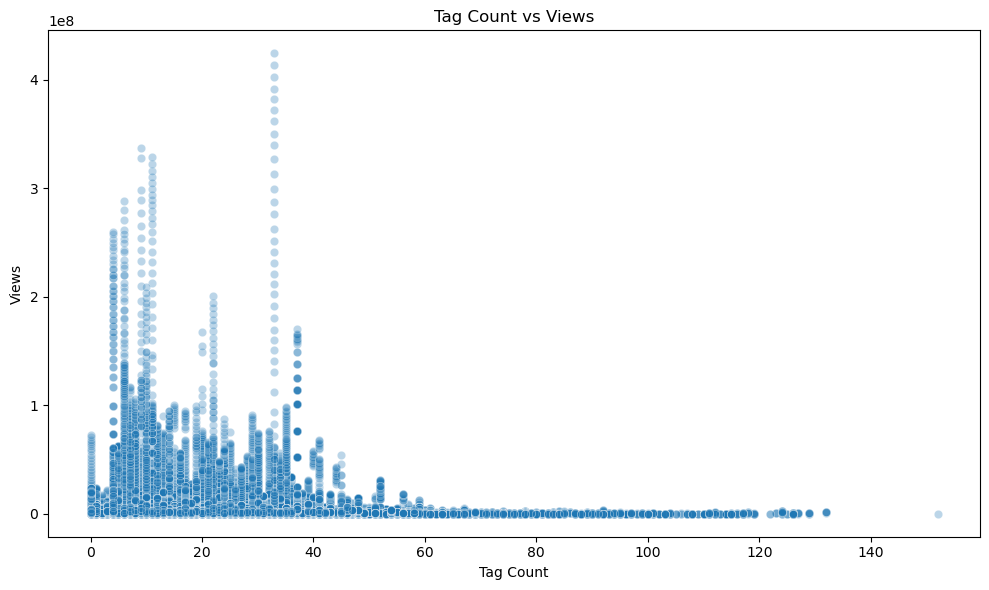

In [820]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=df,x='tag_count',y='views',alpha=0.3)
plt.title('Tag Count vs Views')
plt.xlabel('Tag Count')
plt.ylabel('Views')
plt.tight_layout()
plt.show()

## <div style=" background-color:black; padding: 10px; border-radius: 5px;color:#d4edda"> This Scatter Plot shows that increasing the amount of Tags in the videos wont affect the views

In [822]:
df[['tag_count', 'views']].corr()

,tag_count,views
tag_count,1.000000,0.008342
views,0.008342,1.000000


## <div style=" background-color:black; padding: 10px; border-radius: 5px;color:#d4edda"> This is another way for proving it the correlation is almost zero, so the number of tags in a video wont affect the views

In [824]:
df=df.drop_duplicates()

In [825]:
df

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,...,video_error_or_removed,description,source_file,publish_date,publish_hour,category_name,country,engagements,country_codes,tag_count
0,n1WpP7iowLc,2017-11-14,Eminem - Walk On Water (Audio) ft. Beyoncé,EminemVEVO,10,2017-11-10 17:00:03+00:00,"Eminem|""Walk""|""On""|""Water""|""Aftermath/Shady/In...",17158579,787425,43420,...,False,Eminem's new track Walk on Water ft. Beyoncé i...,CAvideos.csv,2017-11-10,17,Music,CAvideos.csv,913307,CAN,6
1,0dBIkQ4Mz1M,2017-11-14,PLUSH - Bad Unboxing Fan Mail,iDubbbzTV,23,2017-11-13 17:00:00+00:00,"plush|""bad unboxing""|""unboxing""|""fan mail""|""id...",1014651,127794,1688,...,False,STill got a lot of packages. Probably will las...,CAvideos.csv,2017-11-13,17,Comedy,CAvideos.csv,140824,CAN,11
2,5qpjK5DgCt4,2017-11-14,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12 19:05:24+00:00,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146035,5339,...,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...,CAvideos.csv,2017-11-12,19,Comedy,CAvideos.csv,154216,CAN,23
3,d380meD0W0M,2017-11-14,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12 18:01:41+00:00,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095828,132239,1989,...,False,I know it's been a while since we did this sho...,CAvideos.csv,2017-11-12,18,Entertainment,CAvideos.csv,149757,CAN,14
4,2Vv-BfVoq4g,2017-11-14,Ed Sheeran - Perfect (Official Music Video),Ed Sheeran,10,2017-11-09 11:04:14+00:00,"edsheeran|""ed sheeran""|""acoustic""|""live""|""cove...",33523622,1634130,21082,...,False,🎧: https://ad.gt/yt-perfect\n💰: https://atlant...,CAvideos.csv,2017-11-09,11,Music,CAvideos.csv,1719197,CAN,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375937,BZt0qjTWNhw,2018-06-14,The Cat Who Caught the Laser,AaronsAnimals,15,2018-05-18 13:00:04+00:00,"aarons animals|""aarons""|""animals""|""cat""|""cats""...",1685609,38160,1385,...,False,The Cat Who Caught the Laser - Aaron's Animals,USvideos.csv,2018-05-18,13,Pets & Animals,USvideos.csv,40817,USA,14
375938,1h7KV2sjUWY,2018-06-14,True Facts : Ant Mutualism,zefrank1,22,2018-05-18 01:00:06+00:00,[none],1064798,60008,382,...,False,NaN,USvideos.csv,2018-05-18,1,People & Blogs,USvideos.csv,63944,USA,0
375939,D6Oy4LfoqsU,2018-06-14,I GAVE SAFIYA NYGAARD A PERFECT HAIR MAKEOVER ...,Brad Mondo,24,2018-05-18 17:34:22+00:00,I gave safiya nygaard a perfect hair makeover ...,1066451,48068,1032,...,False,I had so much fun transforming Safiyas hair in...,USvideos.csv,2018-05-18,17,Entertainment,USvideos.csv,52060,USA,24
375940,oV0zkMe1K8s,2018-06-14,How Black Panther Should Have Ended,How It Should Have Ended,1,2018-05-17 17:00:04+00:00,"Black Panther|""HISHE""|""Marvel""|""Infinity War""|...",5660813,192957,2846,...,False,How Black Panther Should Have EndedWatch More ...,USvideos.csv,2018-05-17,17,Film & Animation,USvideos.csv,206045,USA,22
